Added import for matplotlib;
Created a new function read_args_default in the configuration file so that the program can run flawless in Jupyter Notebook.
An empty list _recorded_ was created in the first cell in order to make Jupyter Notebook runnable.

In [11]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

from utils.config_utils import read_args, load_config, Dict2Object, read_args_default

recorded = []

Nothing was changed in the net class.

In [12]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


In the train function, I used the torch.max() to compute the predicted values. 
Variables _correct_ and _total_ were created to keep track of the right predictions and total predictions.

The line _correct += (predicted == target).sum().item()_ is the key here. Predict and target are both pytorch tensors, and predicted == target creates a new tensor. We use the sum() method to compute sum of True values (the return value being a tensor), and item() method converts it to a python integer.

Loss value can be achieved directly in the loss variable.

It's worth noting that the training loss here I implemented calculates the loss per item.
Accuracy mutiplied by 100.0 so that we have the percentages.

In [13]:
def train(args, model, device, train_loader, optimizer, epoch):
    """
    tain the model and return the training accuracy
    :param args: input arguments
    :param model: neural network model
    :param device: the device where model stored
    :param train_loader: data loader
    :param optimizer: optimizer
    :param epoch: current epoch
    :return:
    """
    model.train()
    correct = 0
    total = 0
    running_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
        # Compute accuracy
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

        # Accumulate loss
        running_loss += loss.item()
        
    '''Fill your code'''
    training_acc = 100. * correct / total
    training_loss = running_loss / len(train_loader) # Here, training_loss is loss per item. If you want loss per batch, then you can directly return running_loss
    return training_acc, training_loss

Test function is written imitating train function.
we moved the data into target device (on my computer, it should be GPU).
After getting output, we need to get the prediction result (the index).
Then the calculations are done.

In [14]:
def test(model, device, test_loader):
    """
    test the model and return the tesing accuracy
    :param model: neural network model
    :param device: the device where model stored
    :param test_loader: data loader
    :return:
    """
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index
            correct += pred.eq(target.view_as(pred)).sum().item()
            # correct += (pred == target).sum().item()
            
            
    testing_acc, testing_loss = 100. * correct / len(test_loader.dataset), test_loss / len(test_loader.dataset)
    return testing_acc, testing_loss

In [ ]:
Plot performance against epoches.
Added s to display the right name for the y axis.
At last, show the plot.

In [15]:
def plot(epoches, performance, s):
    """
    plot the model peformance
    :param epoches: recorded epoches
    :param performance: recorded performance
    :return:
    """
    """Fill your code"""
    plt.plot(epoches, performance)
    plt.xlabel('Epoch')
    plt.ylabel(s)
    plt.show()

I first append the data into the corresponding list.
To record data, I first created a train_history to contain all the information into one list, and all the data are stored in order.
Then after all the training, the the train-history was recoded into the 'recorded' list.
Thus, I have a three dimentional list recorded[][][], the first brace means the round of training, the second means different data, the third contain all the data orderly.

In [16]:
def run(config):
    use_cuda = not config.no_cuda and torch.cuda.is_available()
    use_mps = not config.no_mps and torch.backends.mps.is_available()

    torch.manual_seed(config.seed)

    if use_cuda:
        device = torch.device("cuda")
    elif use_mps:
        device = torch.device("mps")
    else:
        device = torch.device("cpu")

    train_kwargs = {'batch_size': config.batch_size}
    test_kwargs = {'batch_size': config.test_batch_size}
    if use_cuda:
        cuda_kwargs = {'num_workers': 1,
                       'pin_memory': True,
                       'shuffle': True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)

    # download data
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    dataset1 = datasets.MNIST('./data', train=True, download=True, transform=transform)
    dataset2 = datasets.MNIST('./data', train=False, transform=transform)

    """add random seed to the DataLoader, pls modify this function"""
    train_loader = torch.utils.data.DataLoader(dataset1, **train_kwargs)
    test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

    model = Net().to(device)
    optimizer = optim.Adadelta(model.parameters(), lr=config.lr)

    """record the performance"""
    epoches = []
    training_accuracies = []
    training_loss = []
    testing_accuracies = []
    testing_loss = []

    scheduler = StepLR(optimizer, step_size=1, gamma=config.gamma)
    for epoch in range(1, config.epochs + 1):
        train_acc, train_loss = train(config, model, device, train_loader, optimizer, epoch)
        """record training info, Fill your code"""
        epoches.append(epoch)
        training_accuracies.append(train_acc)
        training_loss.append(train_loss)
        
        test_acc, test_loss = test(model, device, test_loader)
        """record testing info, Fill your code"""
        testing_accuracies.append(test_acc)
        testing_loss.append(test_loss)
        
        
        scheduler.step()
        """update the records, Fill your code"""
        
        """end filling"""

    train_history.append(epoches)
    train_history.append(training_accuracies)
    train_history.append(training_loss)
    train_history.append(testing_accuracies)
    train_history.append(testing_loss)
    
    """plotting training performance with the records"""
    # plot(epoches, training_accuracies, "Training Accuracies")
    plot(epoches, training_loss, "Training Loss")

    """plotting testing performance with the records"""
    plot(epoches, testing_accuracies, "Testing Accuracies")
    plot(epoches, testing_loss, "Testing Loss")

    if config.save_model:
        torch.save(model.state_dict(), "mnist_cnn.pt")

Similarly, compute the average and call the plot function.

In [17]:
def plot_mean():
    """
    Read the recorded results.
    Plot the mean results after three runs.
    :return:
    """
    """fill your code"""
    mean_training_accuracies = []
    mean_training_loss = []
    mean_testing_accuracies = []
    mean_testing_loss = []
    epoches = recorded[0][0]
    for i in range(0, recorded[0][0].__len__()):
        mean_training_accuracies.append((recorded[0][1][i]+recorded[1][1][i]+recorded[2][1][i]) / 3)
        mean_training_loss.append((recorded[0][2][i]+recorded[1][2][i]+recorded[2][2][i]) / 3)
        mean_testing_accuracies.append((recorded[0][3][i]+recorded[1][3][i]+recorded[2][3][i]) / 3)
        mean_testing_loss.append((recorded[0][4][i]+recorded[1][4][i]+recorded[2][4][i]) / 3)
        
    """plotting training performance with the records"""
    # plot(epoches, mean_training_accuracies, "Mean Training Accuracies")
    plot(epoches, mean_training_loss, "Mean Training Loss")

    """plotting testing performance with the records"""
    plot(epoches, mean_testing_accuracies, "Mean Testing Accuracies")
    plot(epoches, mean_testing_loss, "Mean Testing Loss")

Run three times, get the data and set different seed.

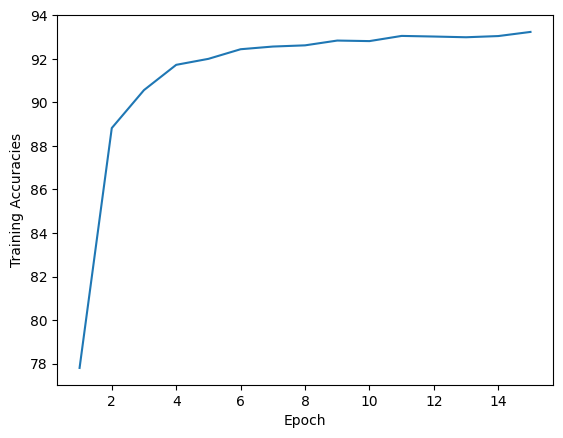

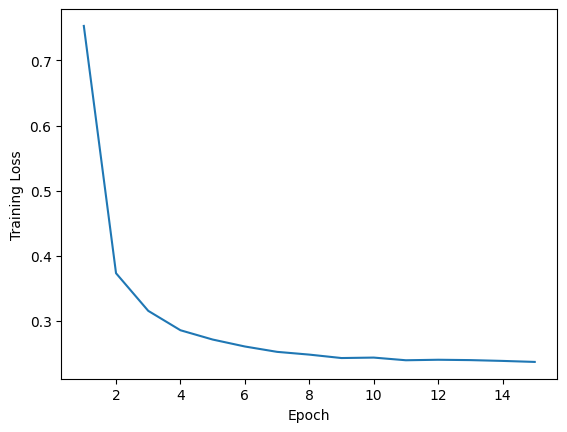

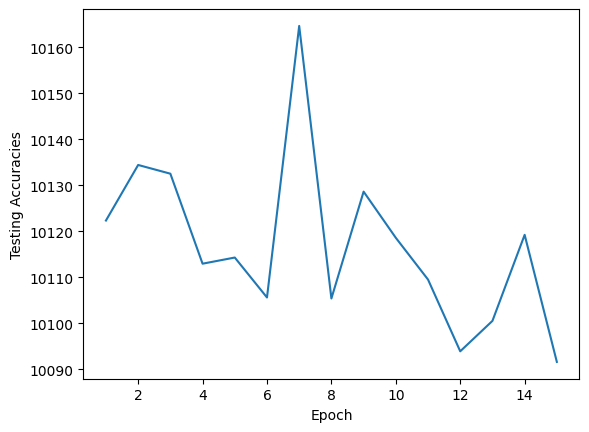

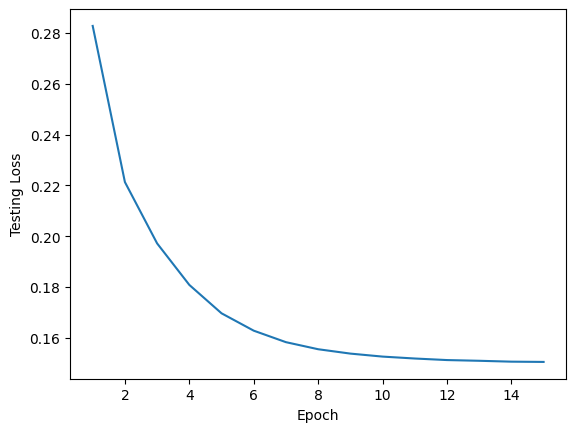

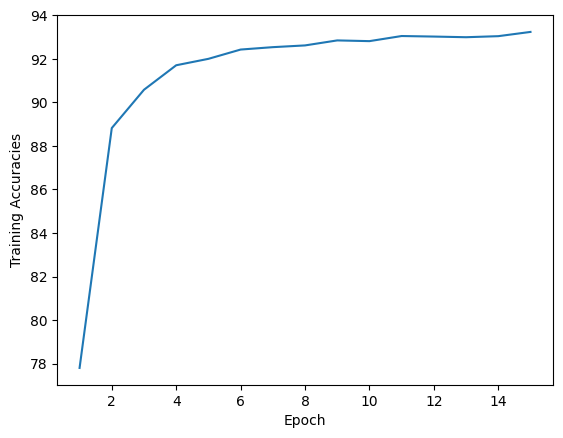

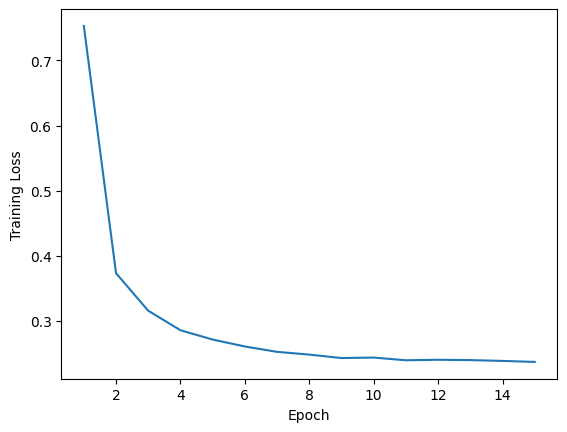

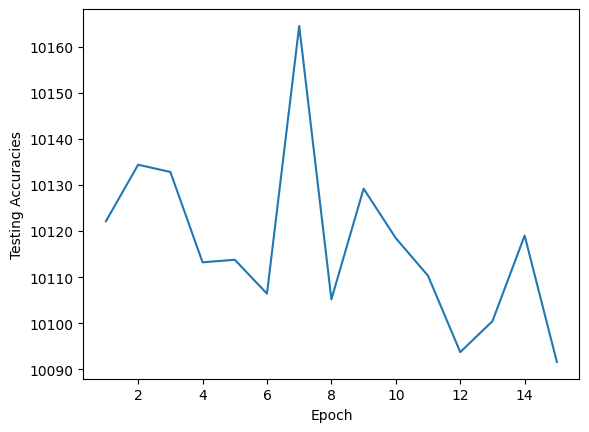

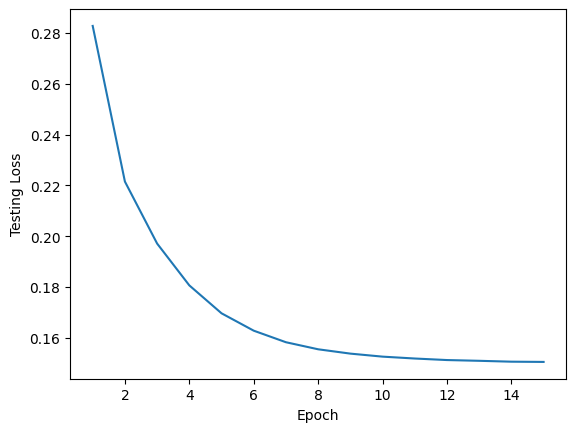

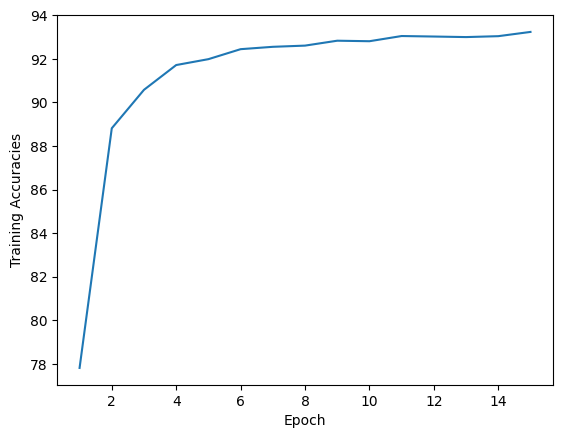

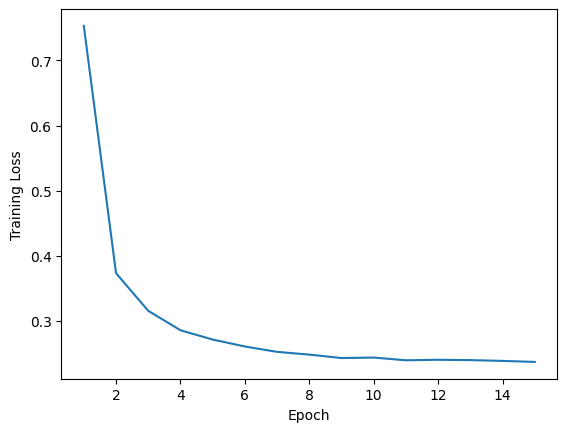

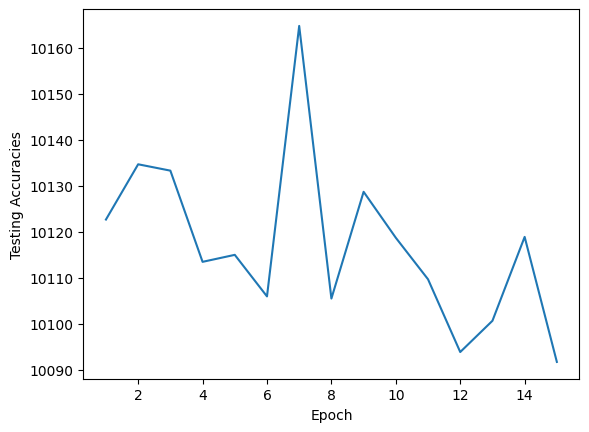

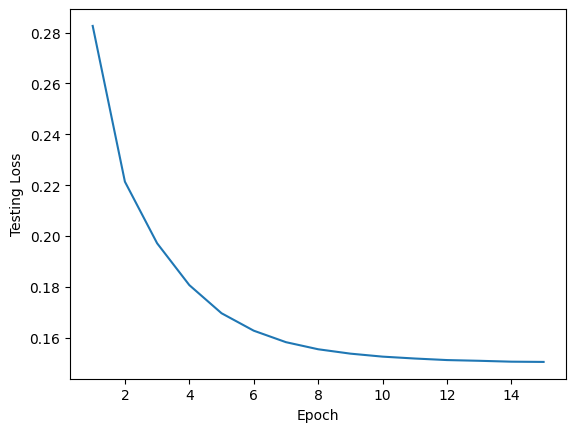

In [18]:
if __name__ == '__main__':
    arg = read_args_default()

    train_history = []
    recorded = []

    """toad training settings"""
    config = load_config(arg)

    """train model and record results"""
    torch.manual_seed(123)
    run(config)
    recorded.append(train_history)
    train_history = []
    
    torch.manual_seed(321)
    run(config)
    recorded.append(train_history)
    train_history = []
    
    torch.manual_seed(666)
    run(config)
    recorded.append(train_history)
    train_history = []

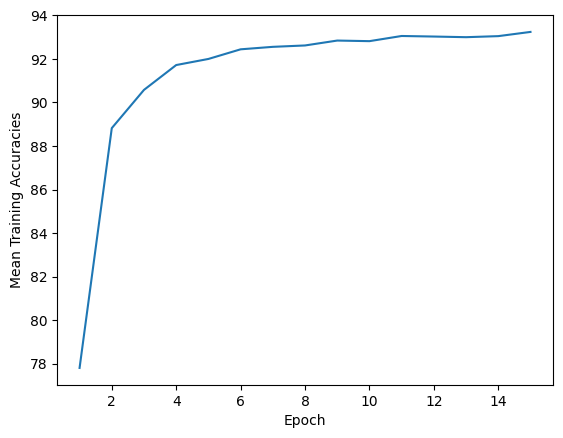

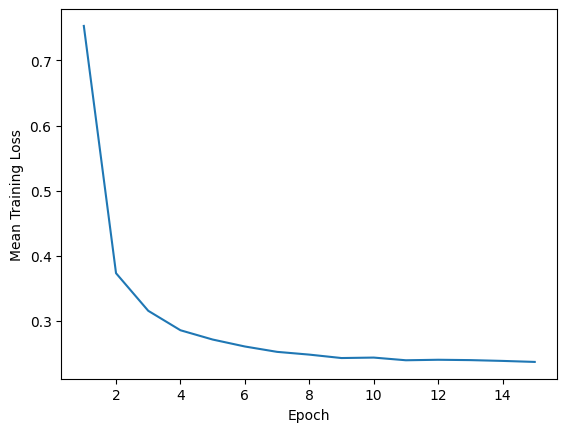

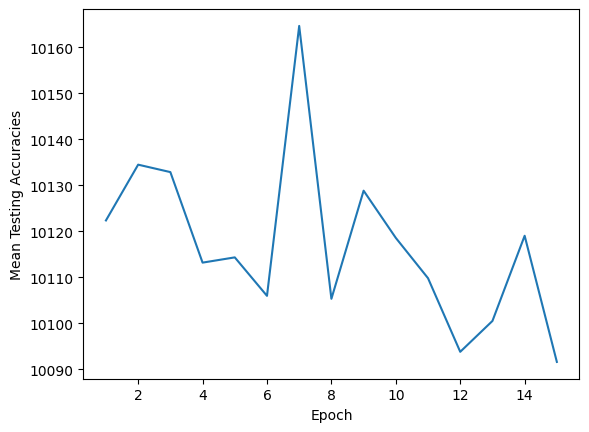

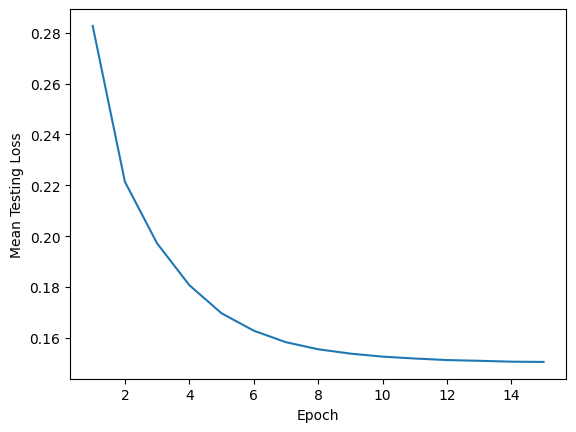

In [19]:
plot_mean()

In [25]:
recorded[2][1]

[77.81833333333333,
 88.81666666666666,
 90.58166666666666,
 91.71833333333333,
 91.98833333333333,
 92.44666666666667,
 92.555,
 92.61,
 92.835,
 92.81166666666667,
 93.05,
 93.02666666666667,
 93.00166666666667,
 93.04333333333334,
 93.23833333333333]